In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [12]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [13]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [14]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [15]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [16]:
# 确保所有列都是数值类型

# --------------------------
# 1. 数据加载和预处理
# --------------------------

all_features = all_features.astype(float)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

epoch 0, train loss 39137767424.000000
epoch 10, train loss 38370148352.000000
epoch 20, train loss 36246884352.000000
epoch 30, train loss 32738940928.000000
epoch 40, train loss 29453244416.000000
epoch 50, train loss 25430931456.000000
epoch 60, train loss 20634460160.000000
epoch 70, train loss 16722598912.000000
epoch 80, train loss 12744906752.000000
epoch 90, train loss 10014996480.000000


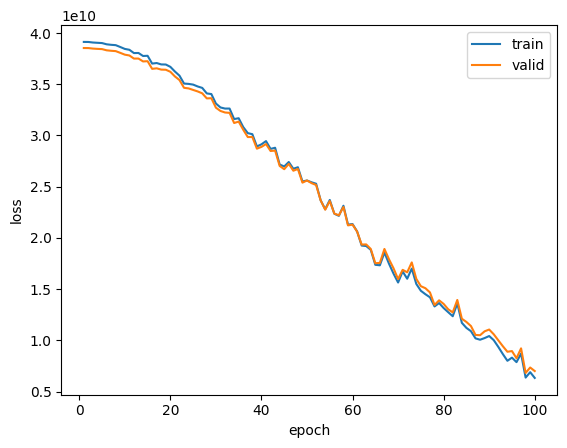

5-折验证: 平均训练log rmse 1265309081.600000, 平均验证log rmse 1399686860.800000
epoch 0, train loss 38772060160.000000
epoch 10, train loss 37967085568.000000
epoch 20, train loss 35923546112.000000
epoch 30, train loss 32333561856.000000
epoch 40, train loss 28433948672.000000
epoch 50, train loss 25185075200.000000
epoch 60, train loss 20561782784.000000
epoch 70, train loss 16321409024.000000
epoch 80, train loss 12013971456.000000
epoch 90, train loss 9276034048.000000
5-折验证: 平均训练log rmse 2682665164.800000, 平均验证log rmse 3013755801.600000
epoch 0, train loss 38372745216.000000
epoch 10, train loss 37583634432.000000
epoch 20, train loss 35562487808.000000
epoch 30, train loss 32722491392.000000
epoch 40, train loss 29055217664.000000
epoch 50, train loss 23974221824.000000
epoch 60, train loss 19595646976.000000
epoch 70, train loss 16393063424.000000
epoch 80, train loss 12942899200.000000
epoch 90, train loss 8477840384.000000
5-折验证: 平均训练log rmse 4035491020.800000, 平均验证log rmse 4612841779.2

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --------------------------
# 2. 定义DenseNet模型
# --------------------------

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm1d(input_channels), nn.ReLU(),
        nn.Linear(input_channels, num_channels))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm1d(input_channels), nn.ReLU(),
        nn.Linear(input_channels, num_channels))

# 构建DenseNet模型
class DenseNet(nn.Module):
    def __init__(self, input_size, num_outputs):
        super(DenseNet, self).__init__()
        
        # 初始层
        self.b1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128), nn.ReLU())
        
        # Dense blocks 和 transition layers
        num_channels, growth_rate = 128, 16
        num_convs_in_dense_blocks = [4, 4, 4, 4]
        blks = []
        
        for i, num_convs in enumerate(num_convs_in_dense_blocks):
            blks.append(DenseBlock(num_convs, num_channels, growth_rate))
            # 上一个稠密块的输出通道数
            num_channels += num_convs * growth_rate
            # 在稠密块之间添加一个转换层，使通道数量减半
            if i != len(num_convs_in_dense_blocks) - 1:
                blks.append(transition_block(num_channels, num_channels // 2))
                num_channels = num_channels // 2
        
        # 最终层
        self.net = nn.Sequential(
            *blks,
            nn.BatchNorm1d(num_channels), nn.ReLU(),
            nn.Linear(num_channels, num_outputs))
    
    def forward(self, x):
        x = self.b1(x)
        x = self.net(x)
        return x

# --------------------------
# 3. 训练函数
# --------------------------

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    
    # 定义损失函数和优化器
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # 创建数据加载器
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    # 训练过程
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        
        # 计算训练损失
        net.eval()
        with torch.no_grad():
            train_l = loss(net(train_features), train_labels)
            train_ls.append(train_l.item())
            
            # 计算测试损失（如果有测试标签）
            if test_labels is not None:
                test_l = loss(net(test_features), test_labels)
                test_ls.append(test_l.item())
        
        # 格式化输出
        if epoch % 10 == 0:
            print(f'epoch {epoch}, train loss {train_ls[-1]:.6f}')
    
    if test_labels is not None:
        return train_ls, test_ls
    else:
        return train_ls

# --------------------------
# 4. K折交叉验证
# --------------------------

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = DenseNet(X_train.shape[1], 1)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.plot(list(range(1, num_epochs + 1)), train_ls, label='train')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls, label='valid')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        # 格式化输出
        print(f'{k}-折验证: 平均训练log rmse {train_l_sum / k:.6f}, '
              f'平均验证log rmse {valid_l_sum / k:.6f}')
    return train_l_sum / k, valid_l_sum / k

# --------------------------
# 5. 模型训练和预测
# --------------------------

# 设置超参数
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0, 64

# 进行K折交叉验证
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse {train_l:.6f}, '
      f'平均验证log rmse {valid_l:.6f}')

# 使用全部数据训练最终模型
net = DenseNet(train_features.shape[1], 1)
train_ls = train(net, train_features, train_labels, None, None, num_epochs, lr,
                 weight_decay, batch_size)

# 预测测试集
net.eval()
with torch.no_grad():
    preds = net(test_features).numpy()

# 保存预测结果
test_data['SalePrice'] = preds
submission = test_data[['Id', 'SalePrice']]
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("预测结果已保存到 submission.csv")